In [9]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s - %(message)s'
)

# Pipeline 

## 1. Định nghĩa tổng quan

## 2. Mô hình LightGBM trong phát hiện rủi ro

### 2.1. I/O

- Một biến nhị phân $(\text{result = \{0, 1\}})$
- Một chỉ số $P(\text{crisis})$ cho biết khả năng xảy ra khủng hoảng đó.

### 2.2. Xây dựng mô hình

In [17]:
import lightgbm as lgb
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def load_risk_data(n_samples: int, seed: int = None) -> pd.DataFrame:
    """
    Tạo dataset giả lập cho phân loại rủi ro ngân hàng.
    """
    if seed is not None:
        np.random.seed(seed)
    
    logging.info(f"Tạo dữ liệu giả lập với {n_samples} mẫu, seed={seed}")
    
    # Credit Risk features
    debt_to_income = np.random.uniform(0.1, 0.8, n_samples)
    ltv = np.random.uniform(0.3, 0.9, n_samples)
    interest_coverage = np.random.uniform(1, 10, n_samples)
    past_defaults = np.random.poisson(0.5, n_samples)
    liabilities_assets = np.random.uniform(0.1, 0.9, n_samples)

    # Market Risk features
    var = np.random.uniform(0.01, 0.2, n_samples)
    beta = np.random.uniform(0.5, 1.5, n_samples)
    volatility = np.random.uniform(0.05, 0.3, n_samples)
    liquidity_ratio = np.random.uniform(0.2, 1.0, n_samples)
    duration = np.random.uniform(1, 10, n_samples)

    # Target rủi ro nhị phân
    target = ((debt_to_income > 0.6) | (var > 0.15)).astype(int)

    df = pd.DataFrame({
        'debt_to_income': debt_to_income,
        'ltv': ltv,
        'interest_coverage': interest_coverage,
        'past_defaults': past_defaults,
        'liabilities_assets': liabilities_assets,
        'var': var,
        'beta': beta,
        'volatility': volatility,
        'liquidity_ratio': liquidity_ratio,
        'duration': duration,
        'target': target
    })
    
    logging.info("Dữ liệu giả lập đã tạo xong")
    return df


In [16]:
def visualize_dataset(df: pd.DataFrame, target_column: str = 'target'):
    """
    Trực quan hóa dataset bao gồm:
    - Histogram cho từng feature
    - Heatmap correlation giữa các feature
    - Phân bố target
    
    Args:
        df (pd.DataFrame): Dataset có các feature và cột target
        target_column (str): Tên cột target
    """
    # 1. Histogram các feature
    features = df.drop(columns=[target_column])
    features.hist(figsize=(15, 10), bins=20, layout=(3, 4), color='skyblue', edgecolor='black')
    plt.suptitle('Feature Distributions', fontsize=16)
    plt.show()
    
    # 2. Correlation heatmap
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()
    
    # 3. Phân bố target
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target_column, data=df, palette='Set2')
    plt.title(f'Target Distribution ({target_column})', fontsize=14)
    plt.show()

In [18]:
def train_lightgbm(n_samples: int = 1000, seed: int = 42):
    # 1. Tải dữ liệu
    df = load_risk_data(n_samples, seed)

    visualize_dataset(df)
    
    # 2. Train/Test split
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    logging.info(f"Dữ liệu chia train/test: {len(X_train)} train / {len(X_test)} test")
    
    # 3. Tạo dataset LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=None, reference=lgb_train)
    
    # 4. Cấu hình model
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'n_estimators': 500,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }
    
    # 5. Huấn luyện
    logging.info("Bắt đầu huấn luyện LightGBM...")
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'test'],
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(10)]  # log mỗi 10 vòng
    )
    logging.info("Huấn luyện hoàn tất")
    
    # 6. Dự đoán xác suất rủi ro
    y_pred_prob = model.predict(X_test)
    logging.info(f"Đã dự đoán xác suất rủi ro cho {len(y_pred_prob)} mẫu test")
    
    return model, X_test, y_pred_prob

[2025-08-17 18:02:11,496] INFO - Tạo dữ liệu giả lập với 1000 mẫu, seed=42
[2025-08-17 18:02:11,499] INFO - Dữ liệu giả lập đã tạo xong


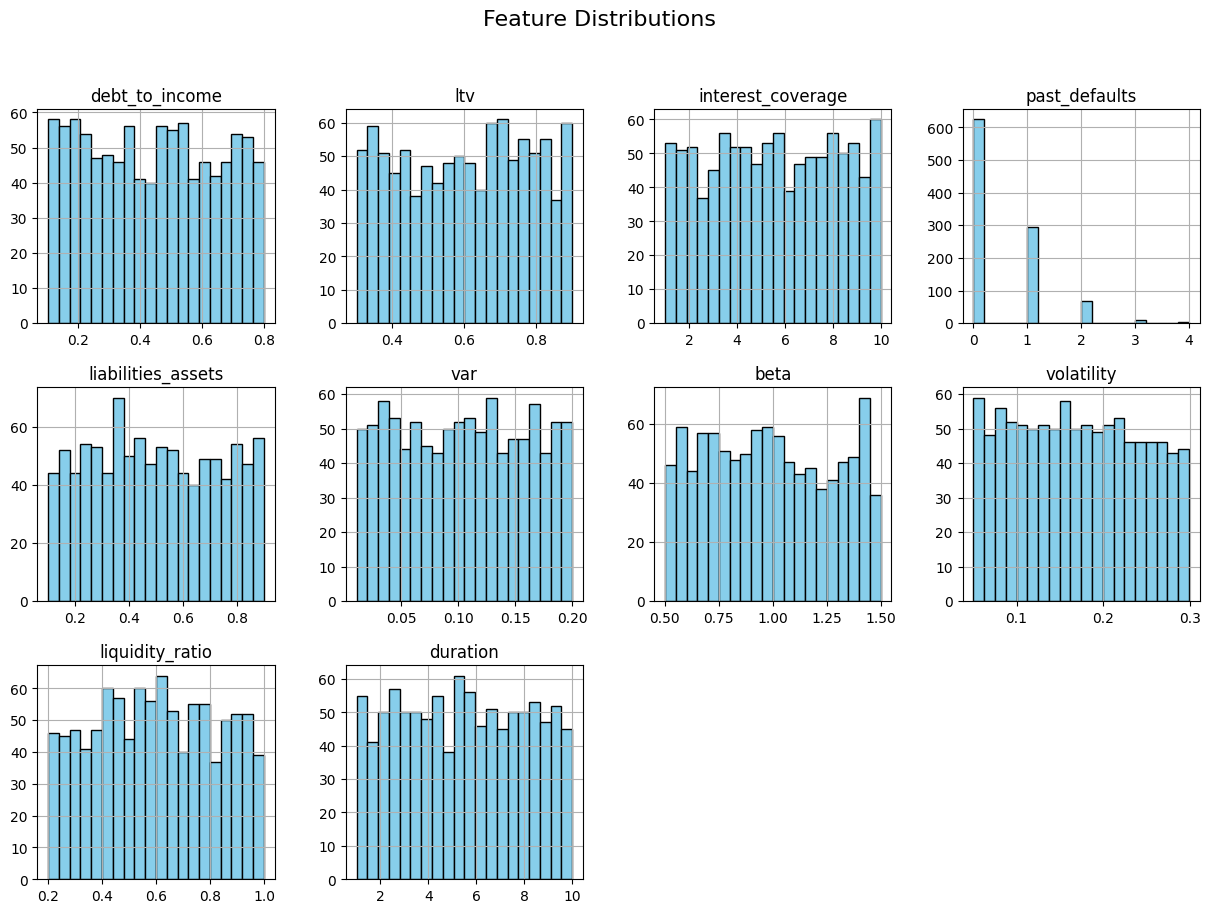

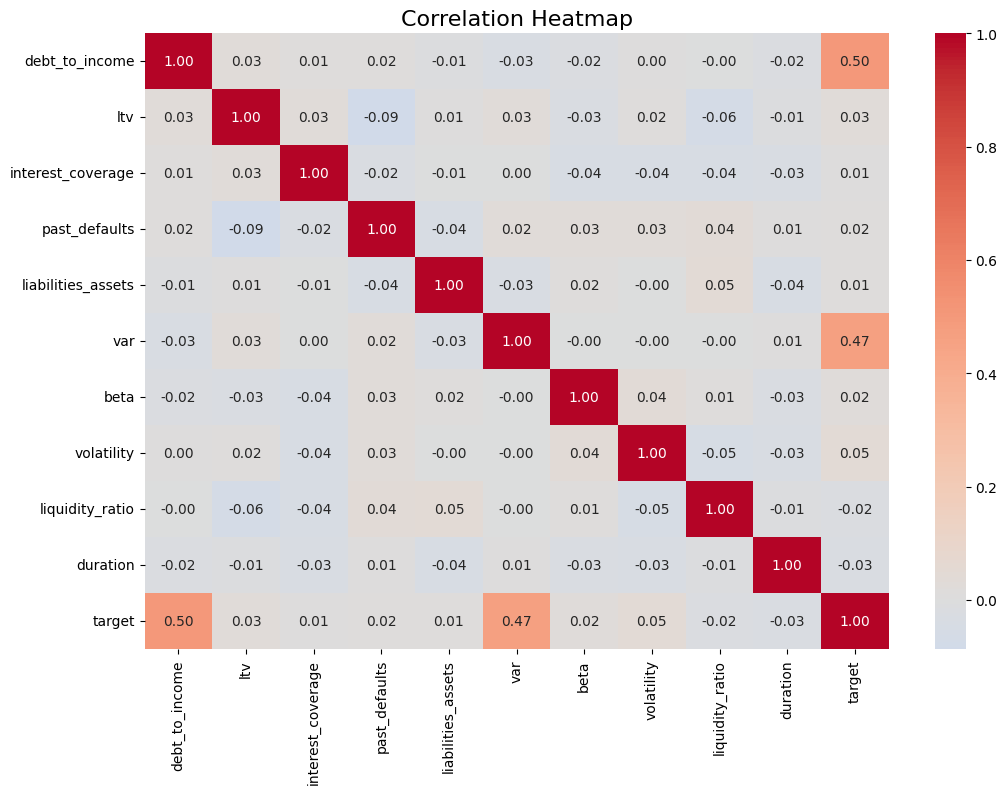

[2025-08-17 18:02:13,345] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\VICTUS\AppData\Local\Temp\ipykernel_21180\303079323.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_column, data=df, palette='Set2')
[2025-08-17 18:02:13,354] INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


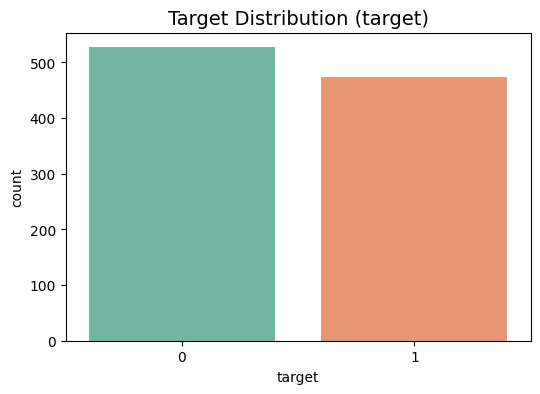

[2025-08-17 18:02:13,436] INFO - Dữ liệu chia train/test: 800 train / 200 test
[2025-08-17 18:02:13,440] INFO - Bắt đầu huấn luyện LightGBM...
[2025-08-17 18:02:13,513] INFO - Huấn luyện hoàn tất
[2025-08-17 18:02:13,515] INFO - Đã dự đoán xác suất rủi ro cho 200 mẫu test


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.999994	test's auc: 1
[20]	train's auc: 0.999994	test's auc: 1
[30]	train's auc: 1	test's auc: 1
[40]	train's auc: 1	test's auc: 1
[50]	train's auc: 1	test's auc: 1
Early stopping, best iteration is:
[1]	train's auc: 0.99973	test's auc: 1
[0.49892725 0.448954   0.49892725 0.448954   0.49892725]


In [19]:
if __name__ == "__main__":
    model, X_test, y_pred_prob = train_lightgbm(n_samples=1000, seed=42)
    print(y_pred_prob[:5])  # kiểm tra 5 xác suất đầu tiên

## 3. Công cụ diễn giải mô hình